# Manhattan Demand Matrix Generation using Grid2Demand

This notebook demonstrates how to use grid2demand to build a travel demand matrix for Manhattan, NYC.

## Overview
- **Tool**: grid2demand
- **Location**: Manhattan, New York City
- **Purpose**: Generate origin-destination (OD) demand matrix for transportation planning

## Requirements
```bash
pip install grid2demand
pip install geopandas pandas matplotlib osmnx
```

## 1. Setup and Imports

In [ ]:
# Install grid2demand if not already installed
# !pip install grid2demand geopandas pandas matplotlib osmnx

In [2]:
import grid2demand as gd
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import os
import warnings
warnings.filterwarnings('ignore')

## 2. Define Manhattan Study Area

We'll define the Manhattan area using bounding box coordinates.

In [5]:
# Manhattan bounding box (approximate)
# Format: (min_longitude, min_latitude, max_longitude, max_latitude)
manhattan_bbox = {
    'min_lon': -74.0479,  # West boundary
    'min_lat': 40.6829,   # South boundary (lower Manhattan)
    'max_lon': -73.9067,  # East boundary
    'max_lat': 40.8820    # North boundary (upper Manhattan)
}

print("Manhattan Study Area Boundaries:")
print(f"  West:  {manhattan_bbox['min_lon']:.4f}°")
print(f"  East:  {manhattan_bbox['max_lon']:.4f}°")
print(f"  South: {manhattan_bbox['min_lat']:.4f}°")
print(f"  North: {manhattan_bbox['max_lat']:.4f}°")

# Calculate approximate dimensions
width_km = (manhattan_bbox['max_lon'] - manhattan_bbox['min_lon']) * 111.32 * 0.7  # rough conversion
height_km = (manhattan_bbox['max_lat'] - manhattan_bbox['min_lat']) * 111.32
print(f"\nApproximate dimensions:")
print(f"  Width:  {width_km:.2f} km")
print(f"  Height: {height_km:.2f} km")

Manhattan Study Area Boundaries:
  West:  -74.0479°
  East:  -73.9067°
  South: 40.6829°
  North: 40.8820°

Approximate dimensions:
  Width:  11.00 km
  Height: 22.16 km


## 3. Download OpenStreetMap Network Data

We'll use OSMnx to download the street network for Manhattan.

In [7]:
# Download Manhattan street network from OpenStreetMap
print("Downloading Manhattan street network from OpenStreetMap...")
print("This may take a few minutes...\n")

# Use place name instead of bounding box for faster download
# OSMnx will query the Nominatim API to get the boundaries
G = ox.graph_from_place(
    "Manhattan, New York City, New York, USA",
    network_type='drive'  # Only drivable roads
)

print(f"✓ Network downloaded successfully!")
print(f"  Nodes (intersections): {len(G.nodes):,}")
print(f"  Edges (road segments): {len(G.edges):,}")

# Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)
print(f"\n✓ Converted to GeoDataFrames")
print(f"  Nodes GDF: {len(nodes_gdf)} rows")
print(f"  Edges GDF: {len(edges_gdf)} rows")

This may take a few minutes...

✓ Network downloaded successfully!
  Nodes (intersections): 4,619
  Edges (road segments): 9,901

✓ Converted to GeoDataFrames
  Nodes GDF: 4619 rows
  Edges GDF: 9901 rows


## 4. Visualize Manhattan Street Network

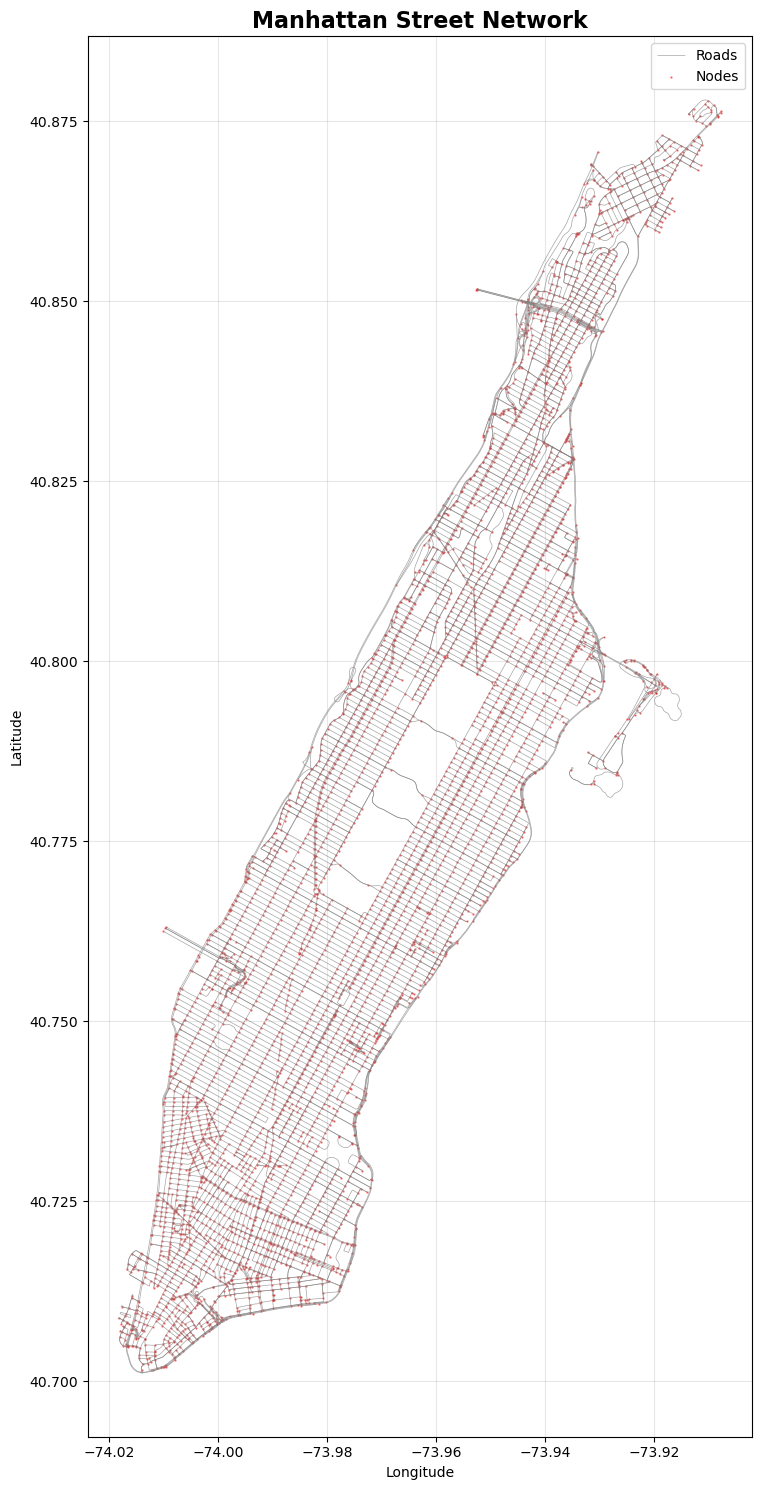

Network visualization complete!


In [8]:
# Visualize the downloaded network
fig, ax = plt.subplots(figsize=(10, 15))

# Plot edges (roads)
edges_gdf.plot(ax=ax, linewidth=0.5, color='gray', alpha=0.7, label='Roads')

# Plot nodes (intersections)
nodes_gdf.plot(ax=ax, markersize=0.5, color='red', alpha=0.5, label='Nodes')

ax.set_title('Manhattan Street Network', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Network visualization complete!")

## 5. Save Network Data for Grid2Demand

Grid2demand requires network data in CSV format. We'll prepare and save the node and link files.

In [20]:
# Create output directory
output_dir = 'manhattan_network_data'
os.makedirs(output_dir, exist_ok=True)

# Prepare node data with all required columns for grid2demand
node_data = pd.DataFrame({
    'node_id': range(len(nodes_gdf)),
    'osm_node_id': nodes_gdf.index,
    'x_coord': nodes_gdf.geometry.x,
    'y_coord': nodes_gdf.geometry.y,
    'longitude': nodes_gdf.geometry.x,
    'latitude': nodes_gdf.geometry.y,
    'activity_type': 'node',  # Required by grid2demand
    'is_boundary': 0,  # 0 = internal node, 1 = boundary node
    'zone_id': -1  # Will be assigned when zones are created
})

# Save node data
node_file = os.path.join(output_dir, 'node.csv')
node_data.to_csv(node_file, index=False)
print(f"✓ Saved node data: {node_file}")
print(f"  Total nodes: {len(node_data):,}")

# Create OSM to sequential node ID mapping
osm_to_seq = dict(zip(nodes_gdf.index, range(len(nodes_gdf))))

# Prepare link data with required columns
links = []
for idx, (u, v, key, data) in enumerate(G.edges(keys=True, data=True)):
    # Parse lanes - handle various formats
    lanes = data.get('lanes', 1)
    if isinstance(lanes, list):
        lanes = int(lanes[0]) if lanes else 1
    elif isinstance(lanes, str):
        try:
            lanes = int(lanes.split(';')[0])  # Take first value if multiple
        except:
            lanes = 1
    else:
        try:
            lanes = int(lanes)
        except:
            lanes = 1
    
    link = {
        'link_id': idx,
        'from_node_id': osm_to_seq[u],
        'to_node_id': osm_to_seq[v],
        'length': data.get('length', 0),  # in meters
        'lanes': lanes,
        'capacity': int(lanes * 1800),  # 1800 vehicles per hour per lane
        'free_speed': 35,  # default 35 mph
        'link_type': str(data.get('highway', 'residential')),
        'geometry': ''  # Optional: can add WKT geometry string
    }
    links.append(link)

link_data = pd.DataFrame(links)

# Save link data
link_file = os.path.join(output_dir, 'link.csv')
link_data.to_csv(link_file, index=False)
print(f"✓ Saved link data: {link_file}")
print(f"  Total links: {len(link_data):,}")

# Create a dummy POI file with all required columns for grid2demand
# Based on error, grid2demand expects: geometry, building, centroid, amenity
dummy_poi = pd.DataFrame({
    'poi_id': [0],
    'x_coord': [node_data['longitude'].mean()],
    'y_coord': [node_data['latitude'].mean()],
    'longitude': [node_data['longitude'].mean()],
    'latitude': [node_data['latitude'].mean()],
    'poi_type': ['placeholder'],
    'name': ['placeholder'],
    'area': [100.0],
    'zone_id': [-1],
    'geometry': ['POINT(0 0)'],  # WKT format
    'building': ['yes'],
    'centroid': ['POINT(0 0)'],
    'amenity': ['placeholder']
})
poi_file = os.path.join(output_dir, 'poi.csv')
dummy_poi.to_csv(poi_file, index=False)
print(f"✓ Created placeholder POI file: {poi_file}")

print(f"\n✓ Network data saved to: {output_dir}/")

✓ Saved node data: manhattan_network_data/node.csv
  Total nodes: 4,619
✓ Saved link data: manhattan_network_data/link.csv
  Total links: 9,901
✓ Created placeholder POI file: manhattan_network_data/poi.csv

✓ Network data saved to: manhattan_network_data/


## 6. Initialize Grid2Demand Network

Now we'll use grid2demand to read the network and create zones.

In [21]:
# Initialize grid2demand network
print("Initializing grid2demand network...\n")

# Create a GRID2DEMAND object (newer API)
net = gd.GRID2DEMAND(input_dir=output_dir)

# Load the network files
net.load_network()

print(f"✓ Network loaded successfully!")
print(f"  Nodes: {len(net.node_dict):,}")
print(f"  POIs: {len(net.poi_dict):,}")
# Note: link information is stored differently in grid2demand
if hasattr(net, 'link_dict'):
    print(f"  Links: {len(net.link_dict):,}")
elif hasattr(net, 'link_list'):
    print(f"  Links: {len(net.link_list):,}")

Initializing grid2demand network...



  : Read nodes: 100%|██████████| 1/1 [00:00<00:00, 243.54it/s]


  : Successfully loaded node.csv: 4619 Nodes loaded.
  :INFO: finished function: read_node, total: 1s 



  : Read poi: 100%|██████████| 1/1 [00:00<00:00, 749.12it/s]

  : Successfully loaded poi.csv: 1 POIs loaded.
  :INFO: finished function: read_poi, total: 0s 

✓ Network loaded successfully!
  Nodes: 4,619
  POIs: 1


## 7. Create Grid-Based Zones

Grid2demand will partition Manhattan into grid-based zones (TAZs - Traffic Analysis Zones).

In [25]:
# Create grid-based zones
# Parameters:
#   - num_x_blocks: number of blocks in longitude direction
#   - num_y_blocks: number of blocks in latitude direction

print("Creating grid-based zones for Manhattan...\n")

# Create a grid (adjustable based on desired granularity)
num_x_blocks = 8   # East-West divisions
num_y_blocks = 16  # North-South divisions

# Generate zones using the correct method name
# Different versions of grid2demand may use different method names
if hasattr(net, 'net2zone'):
    net.net2zone(num_x_blocks=num_x_blocks, num_y_blocks=num_y_blocks)
elif hasattr(net, 'taz_generation'):
    net.taz_generation(num_x_blocks=num_x_blocks, num_y_blocks=num_y_blocks)
elif hasattr(net, 'generate_zone'):
    net.generate_zone(num_x_blocks=num_x_blocks, num_y_blocks=num_y_blocks)
else:
    # Manual zone creation as fallback
    print("  Using manual zone generation...")
    # Get network bounds from node dictionary
    # Nodes are stored as dicts, not objects
    lons = []
    lats = []
    for node in net.node_dict.values():
        if isinstance(node, dict):
            lons.append(node['x_coord'])
            lats.append(node['y_coord'])
        else:
            lons.append(node.x_coord)
            lats.append(node.y_coord)
    
    min_lon, max_lon = min(lons), max(lons)
    min_lat, max_lat = min(lats), max(lats)
    
    print(f"  Network bounds: ({min_lon:.4f}, {min_lat:.4f}) to ({max_lon:.4f}, {max_lat:.4f})")
    
    x_step = (max_lon - min_lon) / num_x_blocks
    y_step = (max_lat - min_lat) / num_y_blocks
    
    # Create zone dictionary
    net.zone_dict = {}
    zone_id = 1
    
    for i in range(num_y_blocks):
        for j in range(num_x_blocks):
            zone_centroid_x = min_lon + (j + 0.5) * x_step
            zone_centroid_y = min_lat + (i + 0.5) * y_step
            
            # Store zones as dictionaries to match grid2demand format
            net.zone_dict[zone_id] = {
                'id': zone_id,
                'zone_id': zone_id,
                'x_coord': zone_centroid_x,
                'y_coord': zone_centroid_y,
                'centroid_x': zone_centroid_x,
                'centroid_y': zone_centroid_y,
                'poi_count': 0,
                'production': 0,
                'attraction': 0,
                'latitude': zone_centroid_y,
                'longitude': zone_centroid_x
            }
            zone_id += 1
    
    print(f"  Created {len(net.zone_dict)} zones manually")

total_zones = num_x_blocks * num_y_blocks
print(f"✓ Grid created successfully!")
print(f"  Grid dimensions: {num_x_blocks} × {num_y_blocks}")
print(f"  Total zones (TAZs): {total_zones}")
print(f"  Zones in network: {len(net.zone_dict)}")

Creating grid-based zones for Manhattan...

  Using manual zone generation...
  Network bounds: (-74.0181, 40.7016) to (-73.9076, 40.8778)
  Created 128 zones manually
✓ Grid created successfully!
  Grid dimensions: 8 × 16
  Total zones (TAZs): 128
  Zones in network: 128


## 8. Download and Process POI (Points of Interest) Data

POIs will be used to estimate trip generation and attraction.

In [27]:
# Download POI data from OpenStreetMap
print("Downloading Points of Interest (POI) from OpenStreetMap...\n")

# Use place name instead of bounding box for faster and more accurate results
place_name = "Manhattan, New York City, New York, USA"

# Get POI data within the place
try:
    # Get buildings
    print("Downloading buildings...")
    buildings = ox.features_from_place(
        place_name,
        tags={'building': True}
    )
    print(f"✓ Downloaded {len(buildings):,} buildings")
    
    # Get amenities
    print("Downloading amenities...")
    amenities = ox.features_from_place(
        place_name,
        tags={'amenity': True}
    )
    print(f"✓ Downloaded {len(amenities):,} amenities")
    
    # Get shops
    print("Downloading shops...")
    shops = ox.features_from_place(
        place_name,
        tags={'shop': True}
    )
    print(f"✓ Downloaded {len(shops):,} shops")
    
    # Get offices
    print("Downloading offices...")
    offices = ox.features_from_place(
        place_name,
        tags={'office': True}
    )
    print(f"✓ Downloaded {len(offices):,} offices")
    
    print(f"\n✓ Total POIs downloaded: {len(buildings) + len(amenities) + len(shops) + len(offices):,}")
    
except Exception as e:
    print(f"Note: Error downloading some POI data: {e}")
    print("Continuing with available data...")


✓ Downloaded 46,343 buildings
✓ Downloaded 26,351 amenities
✓ Downloaded 7,103 shops
✓ Downloaded 840 offices

✓ Total POIs downloaded: 80,637


## 9. Prepare POI Data for Grid2Demand

In [28]:
# Prepare POI data in grid2demand format with all required columns
poi_list = []

# Process buildings
for idx, row in buildings.iterrows():
    try:
        if row.geometry.geom_type == 'Point':
            geom = row.geometry
            centroid = row.geometry
        elif row.geometry.geom_type in ['Polygon', 'MultiPolygon']:
            geom = row.geometry
            centroid = row.geometry.centroid
        else:
            continue
            
        poi_list.append({
            'geometry': geom.wkt,  # WKT format
            'centroid': centroid.wkt,
            'longitude': centroid.x,
            'latitude': centroid.y,
            'x_coord': centroid.x,
            'y_coord': centroid.y,
            'type': 'building',
            'name': row.get('name', 'unnamed'),
            'building': row.get('building', 'yes'),
            'amenity': '',
            'area': geom.area if row.geometry.geom_type in ['Polygon', 'MultiPolygon'] else 100.0,
            'zone_id': -1
        })
    except Exception as e:
        pass

# Process amenities
for idx, row in amenities.iterrows():
    try:
        if row.geometry.geom_type == 'Point':
            geom = row.geometry
            centroid = row.geometry
        elif row.geometry.geom_type in ['Polygon', 'MultiPolygon']:
            geom = row.geometry
            centroid = row.geometry.centroid
        else:
            continue
            
        poi_list.append({
            'geometry': geom.wkt,
            'centroid': centroid.wkt,
            'longitude': centroid.x,
            'latitude': centroid.y,
            'x_coord': centroid.x,
            'y_coord': centroid.y,
            'type': 'amenity',
            'name': row.get('name', row.get('amenity', 'unnamed')),
            'building': '',
            'amenity': row.get('amenity', 'yes'),
            'area': geom.area if row.geometry.geom_type in ['Polygon', 'MultiPolygon'] else 100.0,
            'zone_id': -1
        })
    except Exception as e:
        pass

# Create POI DataFrame
poi_df = pd.DataFrame(poi_list)
poi_df['poi_id'] = range(len(poi_df))

# Reorder columns to match expected format
column_order = ['poi_id', 'x_coord', 'y_coord', 'longitude', 'latitude', 
                'poi_type', 'name', 'area', 'zone_id', 'geometry', 'building', 
                'centroid', 'amenity']
# Only include columns that exist
poi_df = poi_df.rename(columns={'type': 'poi_type'})
existing_cols = [col for col in column_order if col in poi_df.columns]
poi_df = poi_df[existing_cols]

# Save POI data - OVERWRITE the placeholder file
poi_file = os.path.join(output_dir, 'poi.csv')
poi_df.to_csv(poi_file, index=False)

print(f"✓ Prepared {len(poi_df):,} POIs for demand generation")
print(f"✓ Updated POI data: {poi_file}")
print(f"\nPOI Type Distribution:")
print(poi_df['poi_type'].value_counts())

✓ Prepared 72,466 POIs for demand generation
✓ Updated POI data: manhattan_network_data/poi.csv

POI Type Distribution:
poi_type
building    46343
amenity     26123
Name: count, dtype: int64


## 10. Generate Travel Demand Matrix

This is where grid2demand generates the OD (Origin-Destination) demand matrix based on the zones and POI distribution.

In [31]:
# Generate demand matrix
print("Generating travel demand matrix...\n")

# Note: POI file was already updated in previous cell
# We need to reload the network to pick up the new POI data
print("Reloading network with updated POI data...")
net = gd.GRID2DEMAND(input_dir=output_dir)
net.load_network()
print(f"✓ Network reloaded with {len(net.poi_dict):,} POIs")

# Recreate zones (they don't persist through reload)
print("\nRecreating zone grid...")
num_x_blocks = 8
num_y_blocks = 16

# Get network bounds from node dictionary
lons = []
lats = []
for node in net.node_dict.values():
    if isinstance(node, dict):
        lons.append(node['x_coord'])
        lats.append(node['y_coord'])
    else:
        lons.append(node.x_coord)
        lats.append(node.y_coord)

min_lon, max_lon = min(lons), max(lons)
min_lat, max_lat = min(lats), max(lats)

x_step = (max_lon - min_lon) / num_x_blocks
y_step = (max_lat - min_lat) / num_y_blocks

# Create zone dictionary
net.zone_dict = {}
zone_id = 1

for i in range(num_y_blocks):
    for j in range(num_x_blocks):
        zone_centroid_x = min_lon + (j + 0.5) * x_step
        zone_centroid_y = min_lat + (i + 0.5) * y_step
        
        net.zone_dict[zone_id] = {
            'id': zone_id,
            'zone_id': zone_id,
            'x_coord': zone_centroid_x,
            'y_coord': zone_centroid_y,
            'centroid_x': zone_centroid_x,
            'centroid_y': zone_centroid_y,
            'poi_count': 0,
            'production': 0,
            'attraction': 0,
            'latitude': zone_centroid_y,
            'longitude': zone_centroid_x
        }
        zone_id += 1

print(f"✓ Recreated {len(net.zone_dict)} zones")

# Assign POIs to zones
print("\nAssigning POIs to zones...")
from math import sqrt

for poi_id, poi in net.poi_dict.items():
    # Get POI coordinates
    if isinstance(poi, dict):
        poi_x = poi.get('x_coord', poi.get('longitude', 0))
        poi_y = poi.get('y_coord', poi.get('latitude', 0))
    else:
        poi_x = getattr(poi, 'x_coord', getattr(poi, 'longitude', 0))
        poi_y = getattr(poi, 'y_coord', getattr(poi, 'latitude', 0))
    
    # Find nearest zone
    min_dist = float('inf')
    nearest_zone_id = -1
    
    for zone_id, zone in net.zone_dict.items():
        zone_x = zone['x_coord']
        zone_y = zone['y_coord']
        
        # Calculate Euclidean distance
        dist = sqrt((poi_x - zone_x)**2 + (poi_y - zone_y)**2)
        
        if dist < min_dist:
            min_dist = dist
            nearest_zone_id = zone_id
    
    # Assign POI to nearest zone
    if isinstance(poi, dict):
        poi['zone_id'] = nearest_zone_id
    else:
        poi.zone_id = nearest_zone_id
    
    # Update zone POI count
    net.zone_dict[nearest_zone_id]['poi_count'] = net.zone_dict[nearest_zone_id].get('poi_count', 0) + 1

print(f"✓ Assigned {len(net.poi_dict):,} POIs to {len(net.zone_dict)} zones")

# Generate demand matrix using simple production-attraction model
print("\nGenerating demand matrix based on POI distribution...")

# Calculate production and attraction for each zone based on POI count
zone_production = {}
zone_attraction = {}

for zone_id, zone in net.zone_dict.items():
    poi_count = zone.get('poi_count', 0)
    
    # Simple model: production and attraction proportional to POI count
    zone_production[zone_id] = poi_count * 1.0  # 1 trip per POI
    zone_attraction[zone_id] = poi_count * 1.0

total_production = sum(zone_production.values())
total_attraction = sum(zone_attraction.values())

print(f"  Total production: {total_production:,.0f} trips")
print(f"  Total attraction: {total_attraction:,.0f} trips")

# Create OD matrix using gravity model
demand_data = []
zone_ids = list(net.zone_dict.keys())

print("\nCalculating zone-to-zone flows using gravity model...")

for o_zone_id in zone_ids:
    o_zone = net.zone_dict[o_zone_id]
    o_x = o_zone['x_coord']
    o_y = o_zone['y_coord']
    
    for d_zone_id in zone_ids:
        if o_zone_id == d_zone_id:
            continue  # Skip intra-zonal trips for simplicity
        
        d_zone = net.zone_dict[d_zone_id]
        d_x = d_zone['x_coord']
        d_y = d_zone['y_coord']
        
        # Calculate distance
        distance = sqrt((o_x - d_x)**2 + (o_y - d_y)**2)
        
        if distance == 0:
            continue
        
        # Gravity model: T_ij = (P_i * A_j) / (distance^2)
        # With impedance function
        impedance = 1 / (distance ** 1.5)  # Distance decay
        
        volume = zone_production[o_zone_id] * zone_attraction[d_zone_id] * impedance
        
        # Normalize to reasonable trip volumes
        volume = volume / total_production if total_production > 0 else 0
        
        if volume > 0.01:  # Only include non-trivial flows
            demand_data.append({
                'o_zone_id': o_zone_id,
                'd_zone_id': d_zone_id,
                'volume': volume
            })

print(f"✓ Generated {len(demand_data):,} OD pairs")

# Save demand matrix to CSV
import pandas as pd
demand_df = pd.DataFrame(demand_data)
demand_file = os.path.join(output_dir, 'demand.csv')
demand_df.to_csv(demand_file, index=False)

# Also save zone data
zone_data = []
for zone_id, zone in net.zone_dict.items():
    zone_data.append({
        'zone_id': zone_id,
        'x_coord': zone['x_coord'],
        'y_coord': zone['y_coord'],
        'longitude': zone.get('longitude', zone['x_coord']),
        'latitude': zone.get('latitude', zone['y_coord']),
        'poi_count': zone.get('poi_count', 0),
        'production': zone_production.get(zone_id, 0),
        'attraction': zone_attraction.get(zone_id, 0)
    })

zone_df = pd.DataFrame(zone_data)
zone_file = os.path.join(output_dir, 'zone.csv')
zone_df.to_csv(zone_file, index=False)

print("\n✓ Demand generation complete!")
print(f"  Saved: {demand_file}")
print(f"  Saved: {zone_file}")
print(f"  Output directory: {output_dir}/")

Generating travel demand matrix...

Reloading network with updated POI data...


  : Read nodes: 100%|██████████| 1/1 [00:00<00:00, 257.94it/s]


  : Successfully loaded node.csv: 4619 Nodes loaded.
  :INFO: finished function: read_node, total: 0s 



  : Read poi: 100%|██████████| 15/15 [00:00<00:00, 82.77it/s]


  : Successfully loaded poi.csv: 72466 POIs loaded.
  :INFO: finished function: read_poi, total: 0s 

✓ Network reloaded with 72,466 POIs

Recreating zone grid...
✓ Recreated 128 zones

Assigning POIs to zones...
✓ Assigned 72,466 POIs to 128 zones

Generating demand matrix based on POI distribution...
  Total production: 72,466 trips
  Total attraction: 72,466 trips

Calculating zone-to-zone flows using gravity model...
✓ Generated 4,154 OD pairs

✓ Demand generation complete!
  Saved: manhattan_network_data/demand.csv
  Saved: manhattan_network_data/zone.csv
  Output directory: manhattan_network_data/


## 11. Load and Analyze Demand Matrix

In [ ]:
# Load the generated demand matrix
demand_file = os.path.join(output_dir, 'demand.csv')

if os.path.exists(demand_file):
    demand_df = pd.read_csv(demand_file)
    
    print("Demand Matrix Summary:")
    print("=" * 60)
    print(f"Total OD pairs: {len(demand_df):,}")
    print(f"Total trips: {demand_df['volume'].sum():,.0f}")
    print(f"\nTrip Volume Statistics:")
    print(f"  Mean:   {demand_df['volume'].mean():.2f}")
    print(f"  Median: {demand_df['volume'].median():.2f}")
    print(f"  Max:    {demand_df['volume'].max():.2f}")
    print(f"  Min:    {demand_df['volume'].min():.2f}")
    
    # Top 10 OD pairs by volume
    print(f"\nTop 10 OD Pairs by Volume:")
    print(demand_df.nlargest(10, 'volume')[['o_zone_id', 'd_zone_id', 'volume']])
else:
    print(f"Demand file not found: {demand_file}")
    print("Check output directory for generated files.")

## 11b. Interactive OD Visualization Function

This function allows you to select a zone and visualize its origin and destination flows.

In [42]:
def visualize_zone_od_flows(selected_zone_id, top_n=10):
    """
    Visualize origin-destination flows for a selected zone overlaid on Manhattan map.
    
    Parameters:
    -----------
    selected_zone_id : int
        The zone ID to analyze
    top_n : int, default=10
        Number of top destinations/origins to show
    
    Shows:
    ------
    - Map overlay showing streets and shaded grid cells
    - Left panel: Outbound flows with blue arrows
    - Right panel: Inbound flows with green arrows
    """
    
    # Load data
    demand_file = os.path.join(output_dir, 'demand.csv')
    zone_file = os.path.join(output_dir, 'zone.csv')
    
    if not os.path.exists(demand_file) or not os.path.exists(zone_file):
        print("Error: Demand or zone files not found. Run the demand generation cell first.")
        return
    
    demand_df = pd.read_csv(demand_file)
    zone_df = pd.read_csv(zone_file)
    
    # Check if selected zone exists
    if selected_zone_id not in zone_df['zone_id'].values:
        print(f"Error: Zone {selected_zone_id} not found. Valid zones: {zone_df['zone_id'].min()} to {zone_df['zone_id'].max()}")
        return
    
    # Get flows FROM selected zone (destinations)
    outbound_flows = demand_df[demand_df['o_zone_id'] == selected_zone_id].copy()
    outbound_flows = outbound_flows.nlargest(top_n, 'volume')
    
    # Get flows TO selected zone (origins)
    inbound_flows = demand_df[demand_df['d_zone_id'] == selected_zone_id].copy()
    inbound_flows = inbound_flows.nlargest(top_n, 'volume')
    
    # Get selected zone info
    selected_zone = zone_df[zone_df['zone_id'] == selected_zone_id].iloc[0]
    
    # Calculate grid cell dimensions
    num_x = 8
    num_y = 16
    lons = zone_df['x_coord'].values
    lats = zone_df['y_coord'].values
    min_lon, max_lon = lons.min(), lons.max()
    min_lat, max_lat = lats.min(), lats.max()
    x_step = (max_lon - min_lon) / num_x
    y_step = (max_lat - min_lat) / num_y
    
    # Create figure with two maps side by side
    fig, (ax_out, ax_in) = plt.subplots(1, 2, figsize=(24, 12))
    
    # ==================== OUTBOUND FLOWS MAP ====================
    # Plot street network as basemap
    edges_gdf.plot(ax=ax_out, linewidth=0.3, color='#666666', alpha=0.3, zorder=1)
    
    # Draw shaded grid cell for selected zone (red)
    zone_row = int((selected_zone['y_coord'] - min_lat + y_step/2) / y_step)
    zone_col = int((selected_zone['x_coord'] - min_lon + x_step/2) / x_step)
    cell_x = min_lon + zone_col * x_step - x_step/2
    cell_y = min_lat + zone_row * y_step - y_step/2
    
    from matplotlib.patches import Rectangle
    selected_cell = Rectangle((cell_x, cell_y), x_step, y_step,
                              facecolor='red', edgecolor='darkred', 
                              linewidth=2, alpha=0.3, zorder=2)
    ax_out.add_patch(selected_cell)
    
    # Draw shaded grid cells for destination zones (light blue)
    for _, flow in outbound_flows.iterrows():
        dest_zone = zone_df[zone_df['zone_id'] == flow['d_zone_id']].iloc[0]
        dest_row = int((dest_zone['y_coord'] - min_lat + y_step/2) / y_step)
        dest_col = int((dest_zone['x_coord'] - min_lon + x_step/2) / x_step)
        cell_x = min_lon + dest_col * x_step - x_step/2
        cell_y = min_lat + dest_row * y_step - y_step/2
        
        # Shade intensity based on volume
        alpha = 0.2 + 0.3 * (flow['volume'] / outbound_flows['volume'].max())
        
        dest_cell = Rectangle((cell_x, cell_y), x_step, y_step,
                              facecolor='blue', edgecolor='darkblue', 
                              linewidth=1.5, alpha=alpha, zorder=2)
        ax_out.add_patch(dest_cell)
    
    # Add zone centroid marker for selected zone
    ax_out.scatter(selected_zone['x_coord'], selected_zone['y_coord'],
                   c='red', s=500, marker='*', edgecolors='darkred', 
                   linewidths=3, label=f'Selected Zone {selected_zone_id}', zorder=10)
    
    # Draw arrows to destinations
    for _, flow in outbound_flows.iterrows():
        dest_zone = zone_df[zone_df['zone_id'] == flow['d_zone_id']].iloc[0]
        
        # Arrow width proportional to volume
        arrow_width = 1 + 5 * (flow['volume'] / outbound_flows['volume'].max())
        
        ax_out.annotate('',
                       xy=(dest_zone['x_coord'], dest_zone['y_coord']),
                       xytext=(selected_zone['x_coord'], selected_zone['y_coord']),
                       arrowprops=dict(arrowstyle='->', lw=arrow_width, 
                                     color='blue', alpha=0.8),
                       zorder=8)
        
        # Add zone ID label
        ax_out.text(dest_zone['x_coord'], dest_zone['y_coord'], 
                   str(int(dest_zone['zone_id'])),
                   fontsize=10, ha='center', va='center', color='white', 
                   weight='bold', bbox=dict(boxstyle='circle,pad=0.3', 
                   facecolor='blue', edgecolor='darkblue', alpha=0.8),
                   zorder=11)
    
    ax_out.set_title(f'OUTBOUND: Destinations FROM Zone {selected_zone_id}\n' +
                     f'Top {top_n} Destinations Overlaid on Manhattan Street Network',
                     fontsize=14, fontweight='bold', pad=15)
    ax_out.set_xlabel('Longitude', fontsize=11)
    ax_out.set_ylabel('Latitude', fontsize=11)
    ax_out.legend(loc='upper right', fontsize=10)
    ax_out.set_facecolor('#F8F8F8')
    
    # ==================== INBOUND FLOWS MAP ====================
    # Plot street network as basemap
    edges_gdf.plot(ax=ax_in, linewidth=0.3, color='#666666', alpha=0.3, zorder=1)
    
    # Draw shaded grid cell for selected zone (red)
    selected_cell2 = Rectangle((cell_x, cell_y), x_step, y_step,
                               facecolor='red', edgecolor='darkred', 
                               linewidth=2, alpha=0.3, zorder=2)
    ax_in.add_patch(selected_cell2)
    
    # Draw shaded grid cells for origin zones (light green)
    for _, flow in inbound_flows.iterrows():
        origin_zone = zone_df[zone_df['zone_id'] == flow['o_zone_id']].iloc[0]
        origin_row = int((origin_zone['y_coord'] - min_lat + y_step/2) / y_step)
        origin_col = int((origin_zone['x_coord'] - min_lon + x_step/2) / x_step)
        cell_x_origin = min_lon + origin_col * x_step - x_step/2
        cell_y_origin = min_lat + origin_row * y_step - y_step/2
        
        # Shade intensity based on volume
        alpha = 0.2 + 0.3 * (flow['volume'] / inbound_flows['volume'].max())
        
        origin_cell = Rectangle((cell_x_origin, cell_y_origin), x_step, y_step,
                               facecolor='green', edgecolor='darkgreen', 
                               linewidth=1.5, alpha=alpha, zorder=2)
        ax_in.add_patch(origin_cell)
    
    # Add zone centroid marker for selected zone
    ax_in.scatter(selected_zone['x_coord'], selected_zone['y_coord'],
                  c='red', s=500, marker='*', edgecolors='darkred', 
                  linewidths=3, label=f'Selected Zone {selected_zone_id}', zorder=10)
    
    # Draw arrows from origins
    for _, flow in inbound_flows.iterrows():
        origin_zone = zone_df[zone_df['zone_id'] == flow['o_zone_id']].iloc[0]
        
        # Arrow width proportional to volume
        arrow_width = 1 + 5 * (flow['volume'] / inbound_flows['volume'].max())
        
        ax_in.annotate('',
                      xy=(selected_zone['x_coord'], selected_zone['y_coord']),
                      xytext=(origin_zone['x_coord'], origin_zone['y_coord']),
                      arrowprops=dict(arrowstyle='->', lw=arrow_width, 
                                    color='green', alpha=0.8),
                      zorder=8)
        
        # Add zone ID label
        ax_in.text(origin_zone['x_coord'], origin_zone['y_coord'], 
                  str(int(origin_zone['zone_id'])),
                  fontsize=10, ha='center', va='center', color='white', 
                  weight='bold', bbox=dict(boxstyle='circle,pad=0.3', 
                  facecolor='green', edgecolor='darkgreen', alpha=0.8),
                  zorder=11)
    
    ax_in.set_title(f'INBOUND: Origins TO Zone {selected_zone_id}\n' +
                    f'Top {top_n} Origins Overlaid on Manhattan Street Network',
                    fontsize=14, fontweight='bold', pad=15)
    ax_in.set_xlabel('Longitude', fontsize=11)
    ax_in.set_ylabel('Latitude', fontsize=11)
    ax_in.legend(loc='upper right', fontsize=10)
    ax_in.set_facecolor('#F8F8F8')
    
    # Main title
    fig.suptitle(f'Zone {selected_zone_id} OD Flow Analysis - Manhattan\n' +
                f'Location: ({selected_zone["longitude"]:.4f}, {selected_zone["latitude"]:.4f}) | ' +
                f'POI Count: {selected_zone["poi_count"]:,}',
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print(f"ZONE {selected_zone_id} SUMMARY")
    print("="*70)
    print(f"Location: ({selected_zone['longitude']:.4f}, {selected_zone['latitude']:.4f})")
    print(f"POI Count: {selected_zone['poi_count']:,}")
    print(f"Production: {selected_zone['production']:,.0f} trips")
    print(f"Attraction: {selected_zone['attraction']:,.0f} trips")
    print(f"\nOutbound Flows: {len(outbound_flows)} destinations")
    print(f"  Total Volume: {outbound_flows['volume'].sum():.2f}")
    if len(outbound_flows) > 0:
        print(f"  Top Destination: Zone {outbound_flows.iloc[0]['d_zone_id']} ({outbound_flows.iloc[0]['volume']:.2f} trips)")
    print(f"\nInbound Flows: {len(inbound_flows)} origins")
    print(f"  Total Volume: {inbound_flows['volume'].sum():.2f}")
    if len(inbound_flows) > 0:
        print(f"  Top Origin: Zone {inbound_flows.iloc[0]['o_zone_id']} ({inbound_flows.iloc[0]['volume']:.2f} trips)")
    print("="*70)

print("✓ Function visualize_zone_od_flows() loaded successfully!")
print("  - Street network overlay")
print("  - Shaded grid cells (red for selected, blue/green for connections)")
print("  - Flow arrows with thickness proportional to volume")
print("\nUsage: visualize_zone_od_flows(zone_id, top_n=10)")
print(f"Example: visualize_zone_od_flows(64, top_n=15)")


✓ Function visualize_zone_od_flows() loaded successfully!
  - Street network overlay
  - Shaded grid cells (red for selected, blue/green for connections)
  - Flow arrows with thickness proportional to volume

Usage: visualize_zone_od_flows(zone_id, top_n=10)
Example: visualize_zone_od_flows(64, top_n=15)


## 11c. Try the Visualization Function

Use this cell to test the visualization with different zones:

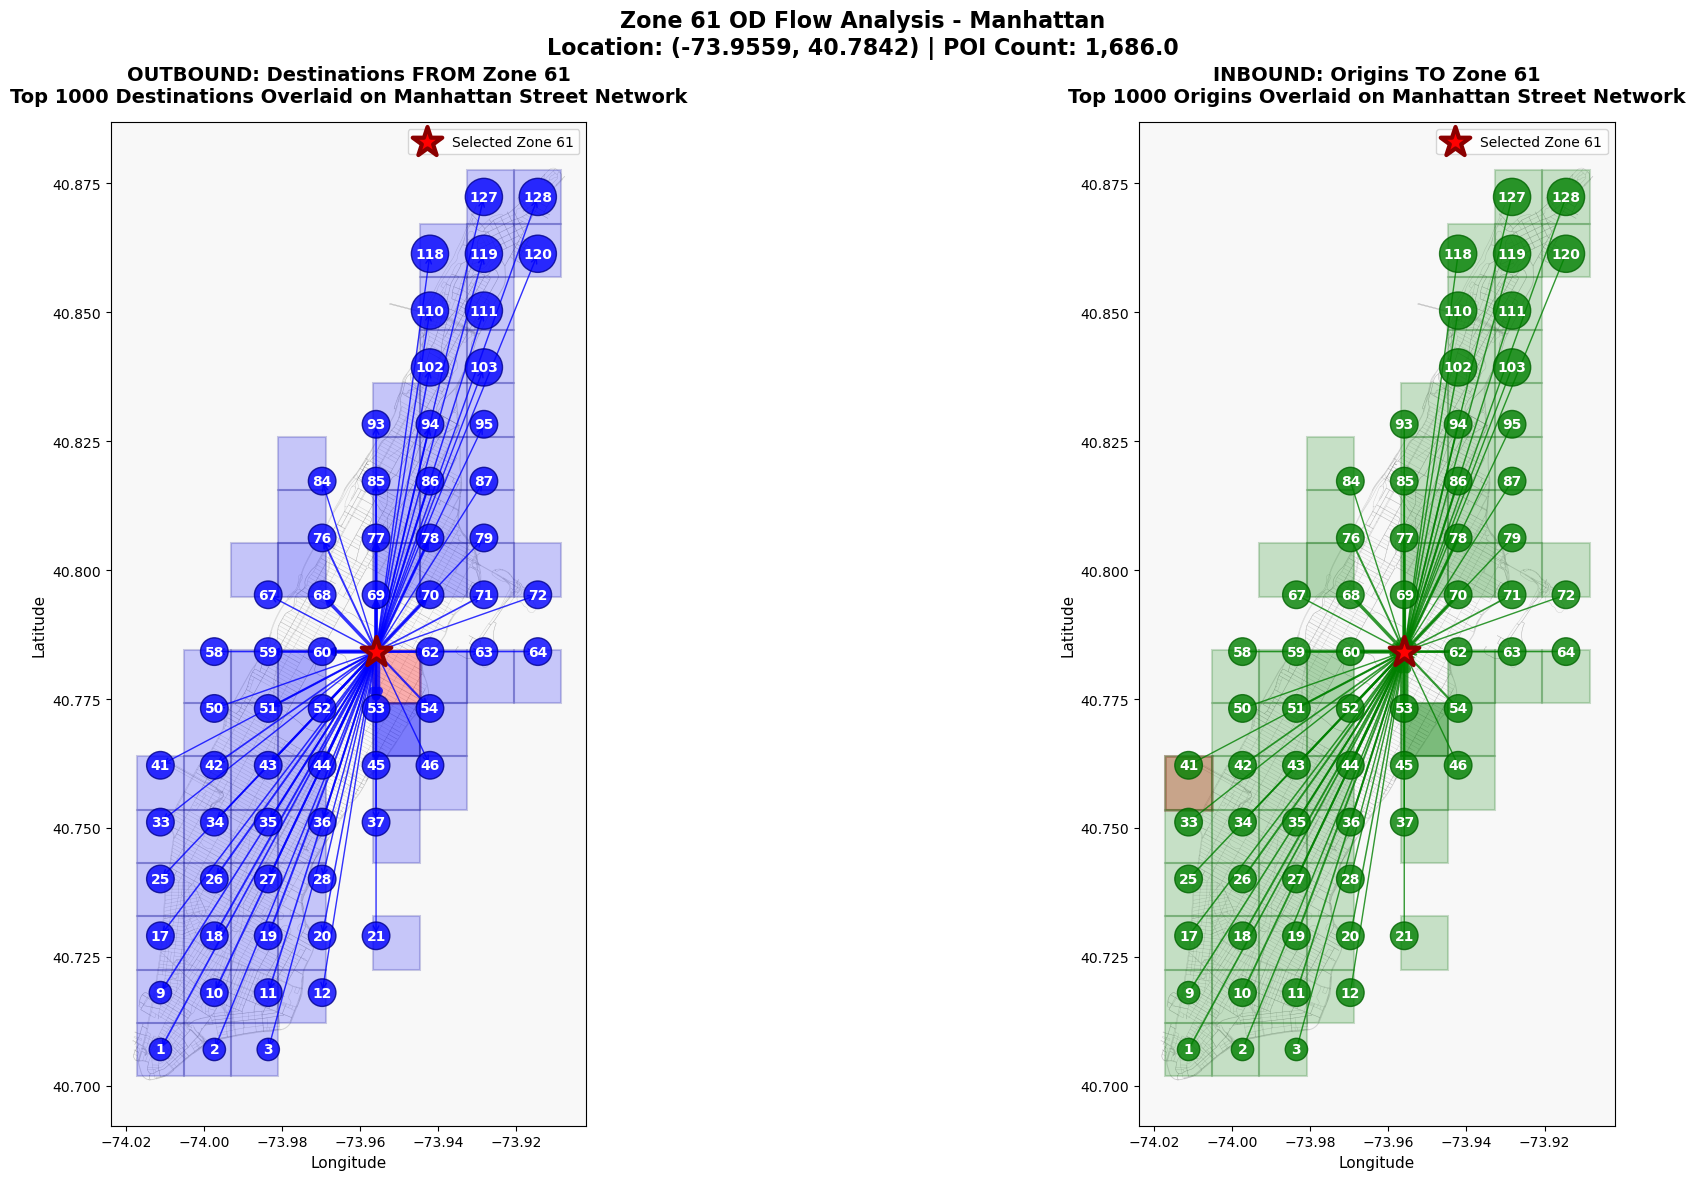


ZONE 61 SUMMARY
Location: (-73.9559, 40.7842)
POI Count: 1,686.0
Production: 1,686 trips
Attraction: 1,686 trips

Outbound Flows: 64 destinations
  Total Volume: 308935.74
  Top Destination: Zone 53.0 (56589.22 trips)

Inbound Flows: 64 origins
  Total Volume: 308935.74
  Top Origin: Zone 53.0 (56589.22 trips)


In [45]:
# Example: Visualize zone 64 (approximately central Manhattan)
visualize_zone_od_flows(61, top_n=1000)

## 12. Visualize Zone Structure

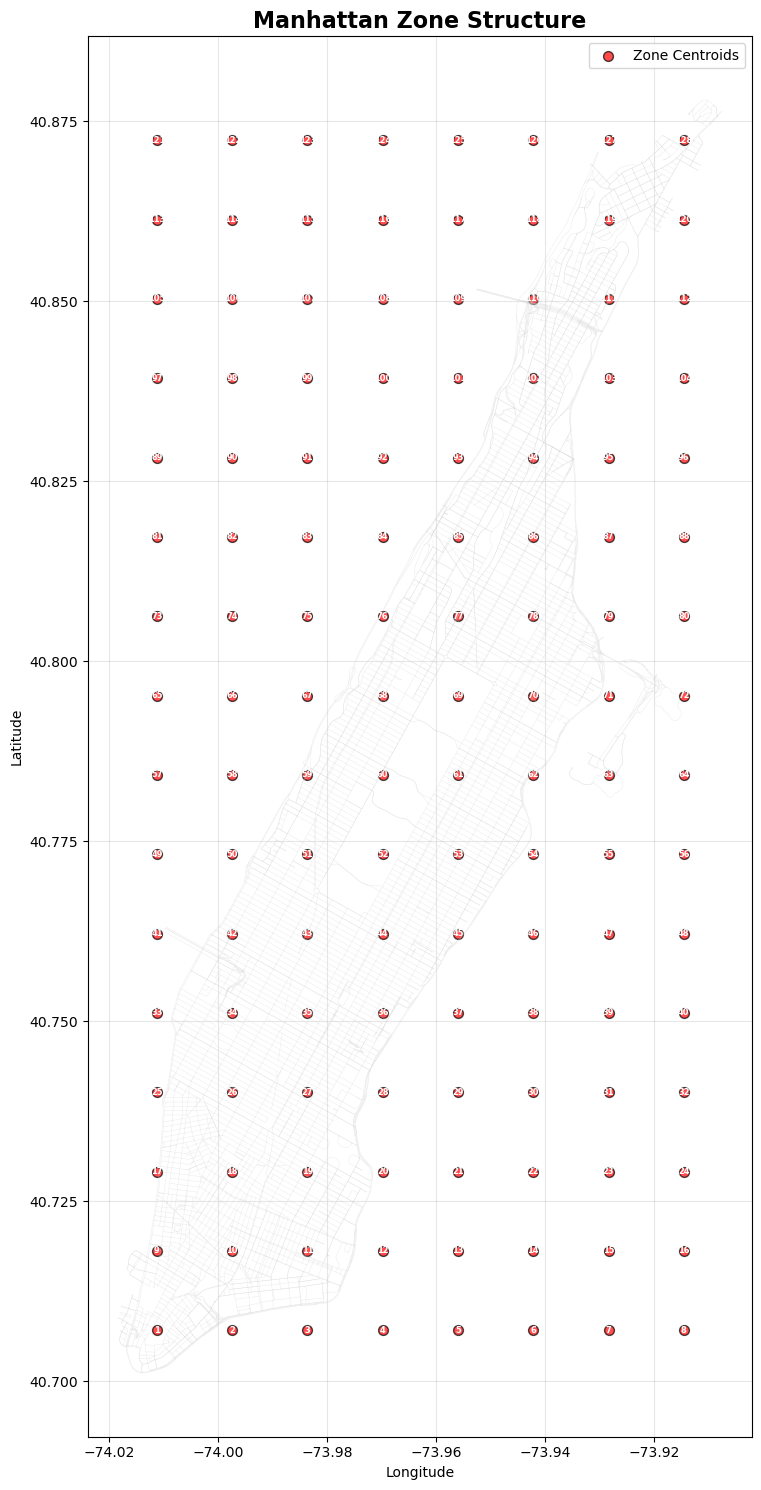


✓ Zone visualization complete!
  Total zones: 128


In [33]:
# Load zone geometry if available
zone_file = os.path.join(output_dir, 'zone.csv')

if os.path.exists(zone_file):
    zone_df = pd.read_csv(zone_file)
    
    fig, ax = plt.subplots(figsize=(10, 15))
    
    # Plot the network
    edges_gdf.plot(ax=ax, linewidth=0.3, color='lightgray', alpha=0.5)
    
    # Plot zone centroids
    zone_gdf = gpd.GeoDataFrame(
        zone_df,
        geometry=gpd.points_from_xy(zone_df['x_coord'], zone_df['y_coord']),
        crs='EPSG:4326'
    )
    
    zone_gdf.plot(ax=ax, markersize=50, color='red', alpha=0.7, 
                  edgecolor='black', linewidth=1, label='Zone Centroids')
    
    # Add zone IDs
    for idx, row in zone_gdf.iterrows():
        ax.annotate(text=row['zone_id'], 
                   xy=(row.geometry.x, row.geometry.y),
                   fontsize=6, ha='center', va='center',
                   color='white', weight='bold')
    
    ax.set_title('Manhattan Zone Structure', fontsize=16, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ Zone visualization complete!")
    print(f"  Total zones: {len(zone_df)}")
else:
    print(f"Zone file not found: {zone_file}")

## 13. Create OD Matrix Heatmap

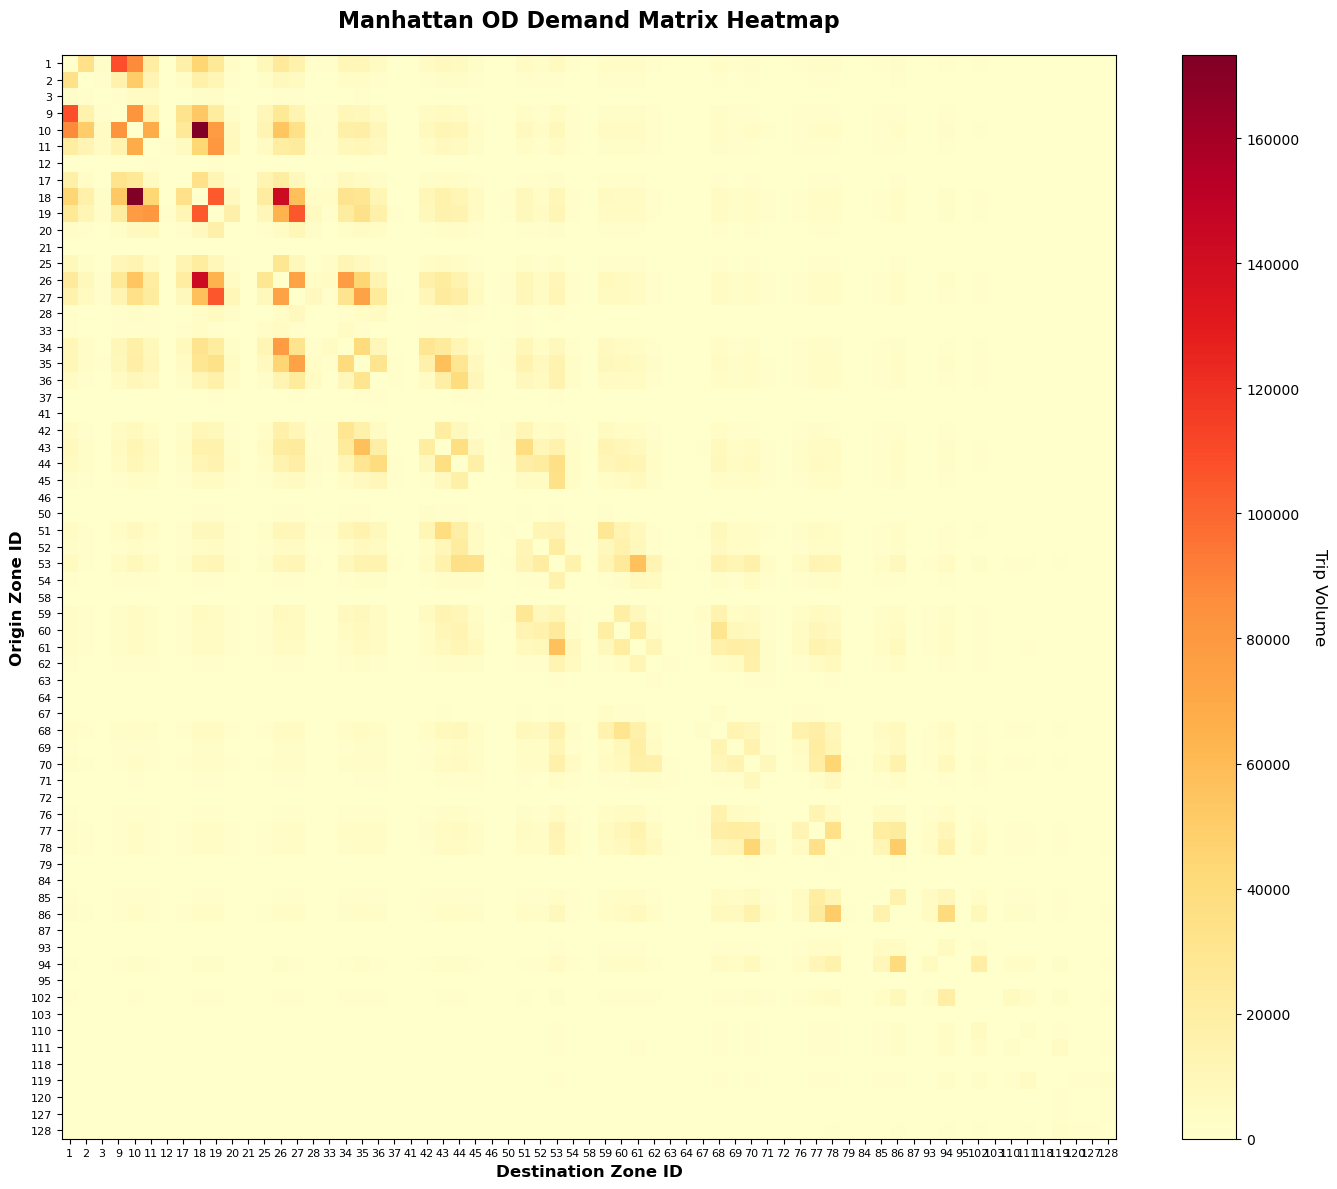

✓ OD Matrix heatmap complete!


In [34]:
if os.path.exists(demand_file):
    # Create OD matrix for visualization
    od_matrix = demand_df.pivot_table(
        index='o_zone_id',
        columns='d_zone_id',
        values='volume',
        fill_value=0
    )
    
    # Plot heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    
    im = ax.imshow(od_matrix, cmap='YlOrRd', aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Trip Volume', rotation=270, labelpad=20, fontsize=12)
    
    # Set ticks
    ax.set_xticks(range(len(od_matrix.columns)))
    ax.set_yticks(range(len(od_matrix.index)))
    ax.set_xticklabels(od_matrix.columns, fontsize=8)
    ax.set_yticklabels(od_matrix.index, fontsize=8)
    
    # Labels
    ax.set_xlabel('Destination Zone ID', fontsize=12, fontweight='bold')
    ax.set_ylabel('Origin Zone ID', fontsize=12, fontweight='bold')
    ax.set_title('Manhattan OD Demand Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ OD Matrix heatmap complete!")
else:
    print("Demand file not available for visualization.")

## 14. Zone-Level Production and Attraction Analysis

Zone-Level Trip Summary:
 zone_id    production    attraction  total_trips
      18 891070.812409 891070.812409 1.782142e+06
      10 826063.004804 826063.004804 1.652126e+06
      26 752854.107577 752854.107577 1.505708e+06
      19 729556.481273 729556.481273 1.459113e+06
      27 625620.187485 625620.187485 1.251240e+06
      35 528431.985108 528431.985108 1.056864e+06
       1 488606.971139 488606.971139 9.772139e+05
      53 462188.072143 462188.072143 9.243761e+05
       9 455344.733832 455344.733832 9.106895e+05
      43 427862.241033 427862.241033 8.557245e+05
      34 419509.739968 419509.739968 8.390195e+05
      44 408414.203594 408414.203594 8.168284e+05
      11 388983.409647 388983.409647 7.779668e+05
      78 312433.059957 312433.059957 6.248661e+05
      61 308935.741981 308935.741981 6.178715e+05
      36 294019.012555 294019.012555 5.880380e+05
      77 290813.176734 290813.176734 5.816264e+05
      51 278402.908278 278402.908278 5.568058e+05
      60 275928.900112 27

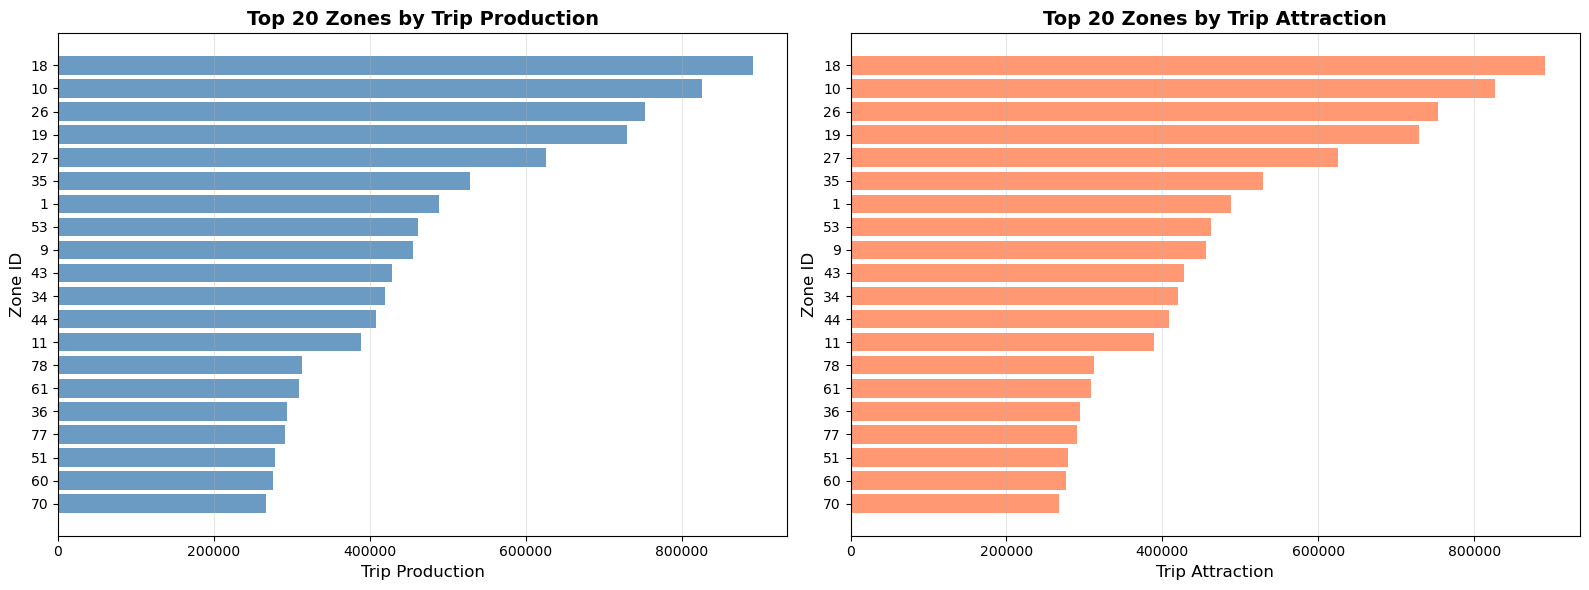


✓ Zone-level analysis complete!


In [35]:
if os.path.exists(demand_file):
    # Calculate production (origins) and attraction (destinations) by zone
    production = demand_df.groupby('o_zone_id')['volume'].sum().reset_index()
    production.columns = ['zone_id', 'production']
    
    attraction = demand_df.groupby('d_zone_id')['volume'].sum().reset_index()
    attraction.columns = ['zone_id', 'attraction']
    
    # Merge production and attraction
    zone_summary = pd.merge(production, attraction, on='zone_id', how='outer').fillna(0)
    zone_summary['total_trips'] = zone_summary['production'] + zone_summary['attraction']
    
    # Sort by total trips
    zone_summary = zone_summary.sort_values('total_trips', ascending=False)
    
    print("Zone-Level Trip Summary:")
    print("=" * 80)
    print(zone_summary.to_string(index=False))
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Production by zone
    zone_summary_plot = zone_summary.head(20)  # Top 20 zones
    ax1.barh(zone_summary_plot['zone_id'].astype(str), zone_summary_plot['production'], 
             color='steelblue', alpha=0.8)
    ax1.set_xlabel('Trip Production', fontsize=12)
    ax1.set_ylabel('Zone ID', fontsize=12)
    ax1.set_title('Top 20 Zones by Trip Production', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    ax1.invert_yaxis()
    
    # Attraction by zone
    zone_summary_plot = zone_summary.sort_values('attraction', ascending=False).head(20)
    ax2.barh(zone_summary_plot['zone_id'].astype(str), zone_summary_plot['attraction'], 
             color='coral', alpha=0.8)
    ax2.set_xlabel('Trip Attraction', fontsize=12)
    ax2.set_ylabel('Zone ID', fontsize=12)
    ax2.set_title('Top 20 Zones by Trip Attraction', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Zone-level analysis complete!")
else:
    print("Demand file not available for analysis.")

## 15. Export Results

In [36]:
# Export final results
print("Exporting final results...\n")

# Check what files were generated
print("Generated files in output directory:")
print("=" * 60)
for file in os.listdir(output_dir):
    file_path = os.path.join(output_dir, file)
    file_size = os.path.getsize(file_path) / 1024  # KB
    print(f"  {file:<30} {file_size:>10.2f} KB")

print("\n" + "=" * 60)
print("MANHATTAN DEMAND MATRIX GENERATION COMPLETE!")
print("=" * 60)
print(f"\nOutput directory: {os.path.abspath(output_dir)}")
print("\nKey files:")
print("  - node.csv: Network nodes")
print("  - link.csv: Network links")
print("  - zone.csv: Traffic analysis zones")
print("  - poi.csv: Points of interest")
print("  - demand.csv: Origin-destination demand matrix")

Exporting final results...

Generated files in output directory:
  zone.csv                             9.95 KB
  demand.csv                          99.76 KB
  node.csv                           313.67 KB
  poi.csv                          24562.49 KB
  link.csv                           522.64 KB

MANHATTAN DEMAND MATRIX GENERATION COMPLETE!

Output directory: /Users/loucas/Documents/ORG/github/custom_notebooks/Various_Testing/manhattan_network_data

Key files:
  - node.csv: Network nodes
  - link.csv: Network links
  - zone.csv: Traffic analysis zones
  - poi.csv: Points of interest
  - demand.csv: Origin-destination demand matrix


## 16. Summary Statistics

In [37]:
print("\n" + "="*80)
print("MANHATTAN DEMAND MATRIX - SUMMARY STATISTICS")
print("="*80)

print(f"\n1. STUDY AREA")
print(f"   Location: Manhattan, New York City")
print(f"   Bounding Box: ({manhattan_bbox['min_lon']:.4f}, {manhattan_bbox['min_lat']:.4f}) to ")
print(f"                 ({manhattan_bbox['max_lon']:.4f}, {manhattan_bbox['max_lat']:.4f})")
print(f"   Approximate Area: {width_km:.2f} km × {height_km:.2f} km")

print(f"\n2. NETWORK CHARACTERISTICS")
print(f"   Total Nodes: {len(node_data):,}")
print(f"   Total Links: {len(link_data):,}")

print(f"\n3. ZONE CONFIGURATION")
print(f"   Grid Dimensions: {num_x_blocks} × {num_y_blocks}")
print(f"   Total Zones: {num_x_blocks * num_y_blocks}")

if os.path.exists(demand_file):
    print(f"\n4. DEMAND MATRIX")
    print(f"   Total OD Pairs: {len(demand_df):,}")
    print(f"   Total Daily Trips: {demand_df['volume'].sum():,.0f}")
    print(f"   Average Trips per OD Pair: {demand_df['volume'].mean():.2f}")
    print(f"   Max Trips (single OD): {demand_df['volume'].max():.0f}")

print(f"\n5. POI DATA")
print(f"   Total POIs: {len(poi_df):,}")
print(f"   POI Types: {poi_df['poi_type'].nunique()}")

print("\n" + "="*80)
print("Analysis complete! Use the generated files for traffic assignment and")
print("further transportation planning analysis.")
print("="*80)


MANHATTAN DEMAND MATRIX - SUMMARY STATISTICS

1. STUDY AREA
   Location: Manhattan, New York City
   Bounding Box: (-74.0479, 40.6829) to 
                 (-73.9067, 40.8820)
   Approximate Area: 11.00 km × 22.16 km

2. NETWORK CHARACTERISTICS
   Total Nodes: 4,619
   Total Links: 9,901

3. ZONE CONFIGURATION
   Grid Dimensions: 8 × 16
   Total Zones: 128

4. DEMAND MATRIX
   Total OD Pairs: 4,154
   Total Daily Trips: 12,811,020
   Average Trips per OD Pair: 3084.02
   Max Trips (single OD): 173346

5. POI DATA
   Total POIs: 72,466
   POI Types: 2

Analysis complete! Use the generated files for traffic assignment and
further transportation planning analysis.
